## Pruning on Fashion MNIST classifier model

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
from numpy import linalg as LA
from scipy.stats import rankdata
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
batch_size   = 64
valid_size   = 0.2
epochs       = 10
min_val_loss = np.Inf
transform    = transforms.ToTensor()  # Convert image to Tensor

In [4]:
# Download the Train and Test set

trainset = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST('.', train=False, download=True, transform=transform)

print("Length of the train set", len(trainset))
print("Length of the test set", len(testset))

Length of the train set 60000
Length of the test set 10000


Label: 2


<IPython.core.display.Javascript object>


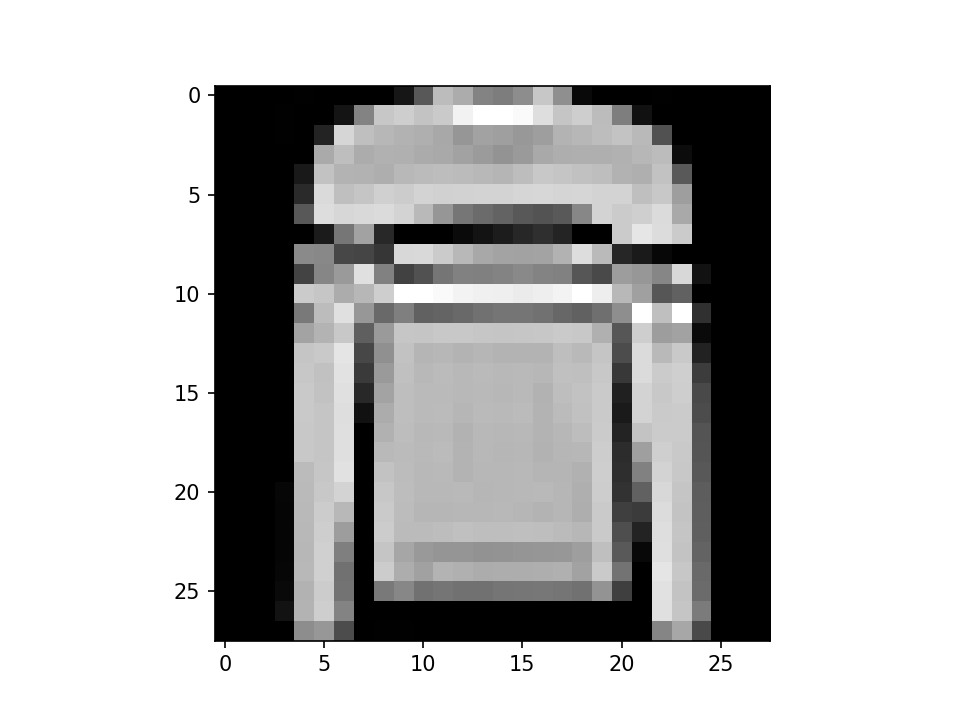

In [5]:
# Sample image from the train set and the label

img_num = 5
print("Label:", trainset[img_num][1])
plt.imshow(trainset[img_num][0][0,:,:],'gray');

In [6]:
# Split the training set indices into training and validation set indices using 80:20 ratio

val_size   = int(len(trainset) * valid_size)
train_size = int(len(trainset) * (1-valid_size))
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

In [7]:
# Create dataloaders for training, validation and testing datasets

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [8]:
# Model Architecture

class FMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1500, bias=False)
        self.fc2 = nn.Linear(1500, 750, bias=False)
        self.fc3 = nn.Linear(750, 300, bias=False)
        self.fc4 = nn.Linear(300, 10, bias=False)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [12]:
# Create model

model = FMNIST()
model

FMNIST(
  (fc1): Linear(in_features=784, out_features=1500, bias=False)
  (fc2): Linear(in_features=1500, out_features=750, bias=False)
  (fc3): Linear(in_features=750, out_features=300, bias=False)
  (fc4): Linear(in_features=300, out_features=10, bias=False)
)

In [13]:
# Defining the Loss function and the Optimization function 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
# Training and Validation

for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    
    model.train()                                # TRAINING
    for image, label in trainloader:
        
        optimizer.zero_grad()                    # Set Gradients to zero
        output = model(image)
        loss   = criterion(output, label)        # Calculate loss according to CrossEntropy
        loss.backward()                          # Backward propagation of loss
        optimizer.step()                         # Run Adam optimiser
        train_loss += loss.item() * image.size(0)# Set train loss as the accumulated sum of loss times the batch size
    
    
    model.eval()                                 # VALIDATION
    for image, label in validloader:
        
        output = model(image)
        loss   = criterion(output, label)
        valid_loss += loss.item() * image.size(0)

    train_loss = train_loss/train_size
    val_loss   = valid_loss/val_size
  
    print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
      epoch+1, 
      train_loss,
      val_loss
      ))
    
    if val_loss <= min_val_loss:                 # Save the model only if val loss has decreased
        print('Validation loss has decreased ({:.5f} --> {:.5f}).  Model saved!'.format(
        min_val_loss,
        val_loss))
        torch.save(model.state_dict(), 'model_pruning.pt')
        min_val_loss = val_loss
    print()

Epoch: 1 	Training Loss: 0.65737 	Validation Loss: 0.50215

Epoch: 2 	Training Loss: 0.47842 	Validation Loss: 0.44791

Epoch: 3 	Training Loss: 0.42713 	Validation Loss: 0.43003
Validation loss has decreased (0.43107 --> 0.43003).  Model saved!

Epoch: 4 	Training Loss: 0.42396 	Validation Loss: 0.45708

Epoch: 5 	Training Loss: 0.42268 	Validation Loss: 0.43044

Epoch: 6 	Training Loss: 0.40405 	Validation Loss: 0.43699

Epoch: 7 	Training Loss: 0.40690 	Validation Loss: 0.42632
Validation loss has decreased (0.43003 --> 0.42632).  Model saved!

Epoch: 8 	Training Loss: 0.39047 	Validation Loss: 0.47083

Epoch: 9 	Training Loss: 0.39040 	Validation Loss: 0.41775
Validation loss has decreased (0.42632 --> 0.41775).  Model saved!

Epoch: 10 	Training Loss: 0.38043 	Validation Loss: 0.44734



In [15]:
# Check accuracy - testing

def test_accuracy(model, testloader, criterion):
    test_loss     = 0.0
    class_correct = list(0. for i in range(10))                        # 10 classes
    class_total   = list(0. for i in range(10))

    model.eval()

    for image, target in testloader:
        
        output = model(image)
        loss   = criterion(output, target)
        test_loss += loss.item()*image.size(0)
        _, pred = torch.max(output, 1)                                 # Get argmax
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))       # Array of 1's and 0's
        
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()                  # Increment if pred==target
            class_total[label]   += 1
    
    overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)# Percentage
    return overall_accuracy

### Exploring pruning

In [16]:
# Ranges for pruning

prune_frac = [0.0, 0.25, 0.50, 0.60, 0.70, 0.75, 0.80, 0.85, 0.90, 0.925, 0.95, 0.975, 0.99]
accuracies_wp = []
accuracies_np = []

# Store initial accuracy 
init_accuracy = test_accuracy(model, testloader, criterion)
accuracies_wp.append(init_accuracy)
accuracies_np.append(init_accuracy)

Pruning can be of two types:<br>
1. **Weight pruning**  
    In weight pruning, for each weight tensor, rank the elements in the order of their absolute values and set the bottom k% of the elements to zero. Setting these elements to zero would mean that we have eliminated those connections reducing the size of the model.
2. **Neuron pruning**  
    In neuron pruning, rank the contribution of the neurons to the output. Instead of removing elements of a tensor, we eliminate k% of the low ranked (according to L1 or L2 norm) columns of the weights.
    
After pruning, the accuracy of the model suffers and that will be demonstrated in the following notebook.  
To overcome this loss, we iteratively train the model after pruning to improve the accuracy of the model until an acceptable accuracy for that model size is achieved.

In [17]:
# Weight Pruning

def weight_pruning(k):
    
    model = FMNIST()
    model.load_state_dict(torch.load('model.pt')) # Load model
    weights = model.state_dict()                  # Load weights
    layers  = list(model.state_dict())            # Get layer names
    ranks   = {}
    pruned_weights = []
    
    for l in layers[:-1]:                         # Do not modify the weights of the output layer
        data = weights[l]
        w    = np.array(data)
        
        ranks[l]=(rankdata(np.abs(w), method='dense') - 1).astype(int).reshape(w.shape)# Rank weight element-wise
        lower_bound_rank = np.ceil(np.max(ranks[l]) * k).astype(int)# Calculate the threshold for bottom k%
        ranks[l][ranks[l] <= lower_bound_rank] = 0                  # 0 below threshold
        ranks[l][ranks[l] > lower_bound_rank] = 1                   # 1 above threshold
        
        w = w * ranks[l]                                            # Set elements below threshold to 0
        
        data[...] = torch.from_numpy(w)                             # Convert weights to tensor
        pruned_weights.append(data)
        
    pruned_weights.append(weights[layers[-1]])                      # Append the output layer weights

    new_state_dict = OrderedDict()                                  # Store and update the weights
    for l, pw in zip(layers, pruned_weights):
        new_state_dict[l] = pw
        
    model.state_dict = new_state_dict
    accuracies_wp.append(test_accuracy(model, testloader, criterion))# Check accuracy with pruned weights 

In [23]:
# Neuron Pruning

def neuron_pruning(k):
    
    model = FMNIST()
    model.load_state_dict(torch.load('model.pt'))
    weights = model.state_dict()
    layers  = list(model.state_dict())
    ranks   = {}
    pruned_weights = []
    
    for l in layers[:-1]:
        data = weights[l]
        w    = np.array(data)
        
        norm = LA.norm(w, axis=0)                        # Taking norm for each neuron
        norm = np.tile(norm, (w.shape[0],1))             # Repeat the norm to the same shape as the weight
        ranks[l] = (rankdata(norm, method='dense') - 1).astype(int).reshape(norm.shape)
        lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
        ranks[l][ranks[l] <= lower_bound_rank] = 0
        ranks[l][ranks[l] > lower_bound_rank] = 1
        
        w = w * ranks[l]
        
        data[...] = torch.from_numpy(w)
        pruned_weights.append(data)
        
    pruned_weights.append(weights[layers[-1]])
    
    new_state_dict = OrderedDict()
    for l, pw in zip(layers, pruned_weights):
        new_state_dict[l] = pw
        
    model.state_dict = new_state_dict
    accuracies_np.append(test_accuracy(model, testloader, criterion))

In [19]:
# Calling weight and neuron pruning

for k in prune_frac[1:]:
    weight_pruning(k)
    neuron_pruning(k)

<IPython.core.display.Javascript object>


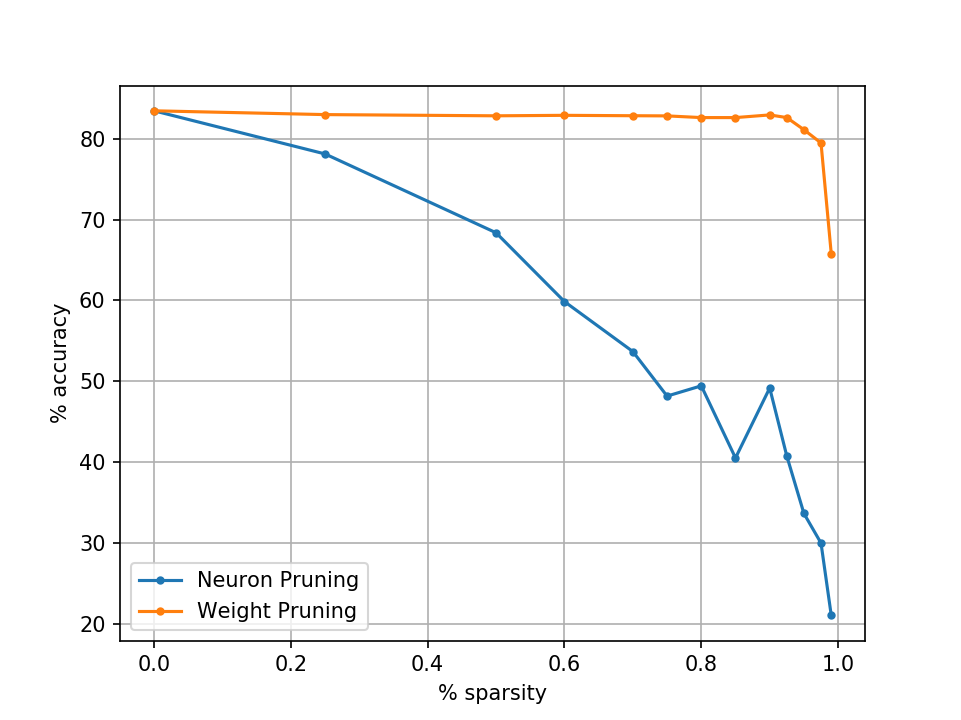

In [21]:
# Plots
plt.figure()

plt.plot(prune_frac, accuracies_np, '.-', label='Neuron Pruning')
plt.plot(prune_frac, accuracies_wp, '.-', label='Weight Pruning')

plt.legend(loc='best')
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')

plt.grid()
plt.show()